In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

import src.models
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


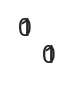

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
prime['len'] = prime['Mutant'].apply(len)
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)

viral_only = pd.read_csv('../data/partitioned_traindata/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

cedar_hp_fold = pd.read_csv('../data/partitioned_traindata/cedar_hp_fold_balanced.csv')
cedar_hp_fold['trainset'] = 'cedar_balanced'

cedar_mut_fold = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')

In [4]:
cedar_related = pd.read_csv('../data/mutant/220927_cedar_related_scored.csv')
prime_related = pd.read_csv('../data/mutant/220927_prime_neoepi_related_scored.csv')

In [5]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


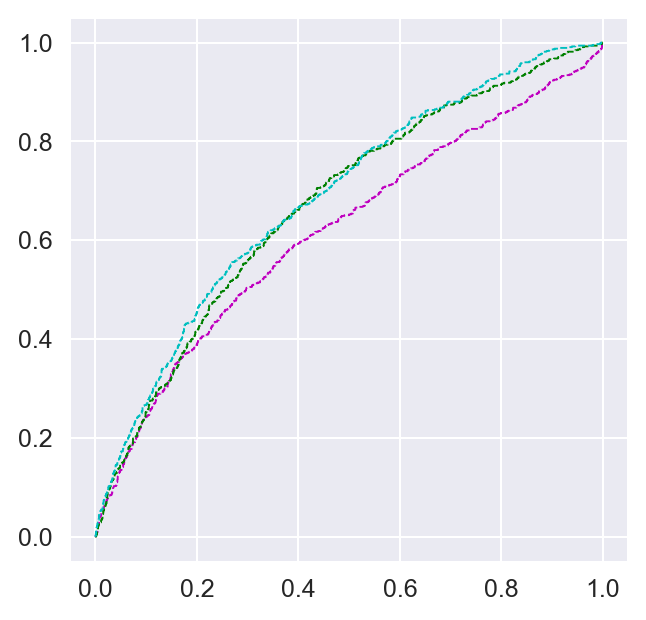

In [6]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [7]:
prime_related.columns.difference(prime_related_baseline.columns)

Index(['Allele', 'IEDB', 'Immunogenicity', 'MixMHCpred', 'NetMHCpanEL',
       'NetMHCpanEL_WT', 'PRIME', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8',
       'aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point'],
      dtype='object')

In [8]:
new_assay = pd.read_excel('../data/raw/neo_OCT2022_full_res_assays.xlsx')
new_epi = pd.read_excel('../data/raw/neo_OCT2022_full_res_epitopes.xlsx')

new_assay

,Reference_T Cell ID,Reference_Reference ID,Reference_Type,Reference_PubMed ID,Reference_Authors,Reference_Journal,Reference_Date,Reference_Title,Reference_Submission ID,Epitope_Epitope ID,Epitope_Object Type,Epitope_Description,Epitope_Starting Position,Epitope_Ending Position,Epitope_Non-peptidic epitope ChEBI ID,Epitope_Antigen Name,Epitope_Parent Protein,Epitope_Parent Protein Accession,Epitope_Organism Name,Epitope_Parent Species,Epitope_Parent Species ID,Epitope_Epitope Comments,Related Object_Epitope Relationship,Related Object_Object Type,Related Object_Description,Related Object_Starting Position,Related Object_Ending Position,Related Object_Non-peptidic object Accession,Related Object_Synonyms,Related Object_Antigen Name,Related Object_Parent Protein,Related Object_Organism Name,Related Object_Parent Organism,Host_Name,Host_Host ID,Host_Geolocation,Host_MHC Types Present,1st in vivo Process_Process Type,1st in vivo Process_Disease State,1st in vivo Process_Disease Stage,1st in vivo Process_Immunogen Epitope Relation,1st in vivo Process_Immunogen Object Type,1st in vivo Process_Immunogen Description,1st in vivo Process_Immunogen Starting Position,1st in vivo Process_Immunogen Ending Position,1st in vivo Process_Non-peptidic Immunogen ChEBI ID,1st in vivo Process_Immunogen Source Molecule Name,1st in vivo Process_Immunogen protein parent Name,1st in vivo Process_Immunogen protein parent Accession,1st in vivo Process_Immunogen Organism Name,1st in vivo Process_Immunogen Organism Species,1st in vivo Process_Immunogen Organism Species Accession,2nd in vivo Process_Process Type,2nd in vivo Process_Disease State,2nd in vivo Process_Disease Stage,2nd in vivo Process_Immunogen Epitope Relation,2nd in vivo Process_Immunogen Object Type,2nd in vivo Process_Immunogen Description,2nd in vivo Process_Immunogen Starting Position,2nd in vivo Process_Immunogen Ending Position,2nd in vivo Process_Non-peptidic Immunogen ChEBI ID,2nd in vivo Process_Immunogen Source Molecule Name,2nd in vivo Process_Immunogen protein parent Name,2nd in vivo Process_Immunogen protein parent Accession,2nd in vivo Process_Immunogen Organism Name,2nd in vivo Process_Immunogen Organism Species,2nd in vivo Process_Immunogen Organism Species Accession,In Vitro Process_In Vitro Process Type,In Vitro Process_Responder Cell Type,In Vitro Process_Stimulator Cell Type,In Vitro Process_Immunogen Epitope Relation,In Vitro Process_Immunogen Object Type,In Vitro Process_Immunogen Description,In Vitro Process_Non-peptidic Immunogen ChEBI ID,In Vitro Process_Immunogen Source Molecule Name,In Vitro Process_Protein Parent Name,In Vitro Process_Protein Parent Accession,In Vitro Process_Immunogen Organism Name,In Vitro Process_Immunogen Organism Species,In Vitro Process_Immunogen Organism Species ID,Adoptive Transfer_Adoptive Transfer Flag,Adoptive Transfer_Adoptive Transfer Comments,Immunization Comments_Immunization Comments,Assay_Location of assay data in the manuscript,Assay_Method/Technique,Assay_Assay Group,Assay_Units,Assay_Qualitative Measure,Assay_Measurement Inequality,Assay_Quantitative measurement,Assay_Number of Subjects Tested,Assay_Number of Subjects Responded,Assay_Response Frequency,Effector Cells_Cell Tissue Type,Effector Cells_Cell Type,Effector Cells_Cell Culture Conditions,TCR_Assayed TCR Molecule Name,TCR_PDB ID,Antigen Presenting Cells_Cell Tissue Type,Antigen Presenting Cells_Cell Type,Antigen Presenting Cells_Cell Culture Conditions,MHC_Allele Name,MHC_Class,MHC_Allele Evidence Code,Assay Antigen_Antigen Epitope Relation,Assay Antigen_Antigen Object Type,Assay Antigen_Antigen Description,Assay Antigen_Starting Position,Assay Antigen_Ending Position,Assay Antigen_Non-peptidic Antigen ChEBI ID,Assay Antigen_Antigen Source Molecule Name,Assay Antigen_Protein Parent Name,Assay Antigen_Protein Parent Accession,Assay Antigen_Antigen Organism Name,Assay Antigen_Organism Species Name,Assay Antigen_Organism Species ID,Assay Comments_Assay Comments,qual,full.r

In [34]:
new_assay['len_wt'] = new_assay['Related Object_Description'].apply(len)
new_assay['len'] = new_assay['Epitope_Description'].apply(len)
new_assay.query('true_wt and len>12 and not `MHC_Allele Name`.str.contains("D")', engine='python')[['Epitope_Description', 'Related Object_Description', 'len', 'len_wt', 'MHC_Allele Name']]

,Epitope_Description,Related Object_Description,len,len_wt,MHC_Allele Name
121,SWISDIRAGTAPLCRNHIKSSCSLI,SWISDIRAGTAPSCRNHIKSSCSLI,25,25,HLA-B*51:01
122,RKTVRARSRTPSCRSRSHTPSRRRR,RKTVRARSRTPSRRSRSHTPSRRRR,25,25,HLA-B*07:02
619,GDRFCLGQLSNAHRT,GDRFCLGQLSNVHRT,15,15,HLA-A*02:01
620,GDRFCLGQLSNAHRT,GDRFCLGQLSNVHRT,15,15,HLA-A*02:01
621,GDRFCLGQLSNAHRT,GDRFCLGQLSNVHRT,15,15,HLA-A*02:01
...,...,...,...,...,...
3948,HTGEKPYRCKVCGTAFTWHSQLARH,HTGEKPYRCKVCDTAFTWHSQLARH,25,25,HLA-A*32:01
3949,LLMREVPLRCTISLWDTYQSEPDGF,LLMREVPLRCTIRLWDTYQSEPDGF,25,25,HLA-A*01:01
3950,LVRAVQFTETFLMERDKQSKWSGIP,LVRAVQFTETFLTERDKQSKWSGIP,25,25,HLA-B*44:03
3951,HTGEKPYRCKVCGTAFTWHSQLARH,HTGEKPYRCKVCDTAFTWHSQLARH,25,25,HLA-A*32:01


In [24]:
new_assay['true_wt'] = new_assay['Related Object_Description'].apply(lambda x: x.upper()==x)
len(new_assay.query('true_wt')['Epitope_Description'].unique())

3805